In [1]:
import pennylane as qml
import torch
import matplotlib.pyplot as plt
import pennylane as pl
from torch import nn
from pennylane import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split 
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import sys
sys.path.insert(0, "../")
import utils.utils as utils
import models.fourier_models as fm
import models.quantum_models as qm

##  Rescaling of the features and the output target.
- The features are rescaled to the interval [-pi/2, pi/2]
- The target are rescaled to the interval [0.15, 5]


In [9]:
# Assuming fetch_california_housing is already defined and imported
data = fetch_california_housing()
X = torch.from_numpy(data.data).float()
y = torch.from_numpy(data.target).float()

# Split the dataset into training + validation and testing (hold-out set)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2)

# Further split the training + validation set into separate training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=2)  # 25% of X_train_val will be X_val

# Now we scale the data, ensuring no data leakage happens

# Calculate scaling parameters (min and max in this case) only from the training set
min_value, max_value = X_train.min(dim=0)[0], X_train.max(dim=0)[0]

# Scale the training data
X_train_scaled = utils.data_scaler(X_train, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))

# Apply the same scaling to the validation and test data
X_val_scaled = utils.data_scaler(X_val, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))
X_test_scaled = utils.data_scaler(X_test, min_value=min_value, max_value=max_value, interval=(-torch.pi/2, torch.pi/2))


# Create TensorDatasets and DataLoaders with the scaled data
train_dataset = TensorDataset(X_train_scaled, y_train)
val_dataset = TensorDataset(X_val_scaled, y_val)
test_dataset = TensorDataset(X_test_scaled, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=500)
test_dataloader = DataLoader(test_dataset, batch_size=500)

# Note: Typically, we do not need to shuffle the validation and test sets

##  Defintion of a Train and Test function
- Define a closure function for the LBFGS optimizer and average the loss per batch for uniformity in processing the data.
- Define an evaluation function that computes the training and validation loss during the learning process and the test loss to validate the model at the end


In [10]:
# Define training function
def train(dataloader, model, loss_fn, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    num_batches = len(dataloader)

    for X, y in dataloader:
        # Define the closure function
        def closure():
            optimizer.zero_grad()
            output = model(X)
            loss = loss_fn(output.squeeze(), y)  # Compute loss
            loss.backward()  # Perform backpropagation
            return loss

        loss = closure()  # Compute the loss and perform backpropagation
        optimizer.step(closure)  # Update model parameters using the optimizer

        total_loss += loss.item()  # Accumulate the loss

    average_loss_per_batch = total_loss / num_batches  # Calculate the average loss
    return average_loss_per_batch


def evaluate(dataloader, model, loss_fn):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            output = model(X).squeeze()  # Compute model output
            loss = loss_fn(output, y).item()  # Calculate loss
            total_loss += loss  # Accumulate the total loss

    num_batches = len(dataloader)
    average_loss_per_batch = total_loss / num_batches  # Calculate the average loss per batch
    
    # Return the average loss per batch
    return average_loss_per_batch

##  3- Initialization of the model and training loop
- We generate W with max frequency two for the Fourier Model
- Loss function set to MSE
- Optimizer set to LBFGS
- We iterate 7 runs over 50 epochs each in which we print 
    - The train loss
    - The validation Loss
    - The Test loss of the run
- We plot the loss functions in the same graph and print the average test loss over all 7 runs    


#### 3-a W is generated with Mode = "half"
execution time = 1093 min 16.2 s

Run 1/7
-------------------------------
Epoch 1/50
Train Loss: 0.7093
Validation Loss: 0.4626
Epoch 2/50
Train Loss: 0.4683
Validation Loss: 0.4699
Epoch 3/50
Train Loss: 0.4527
Validation Loss: 0.4710
Epoch 4/50
Train Loss: 0.4333
Validation Loss: 0.4646
Epoch 5/50
Train Loss: 0.4326
Validation Loss: 0.4868
Epoch 6/50
Train Loss: 0.4326
Validation Loss: 0.5492
Epoch 7/50
Train Loss: 0.4305
Validation Loss: 0.4534
Epoch 8/50
Train Loss: 0.4261
Validation Loss: 0.4671
Epoch 9/50
Train Loss: 0.4182
Validation Loss: 0.4891
Epoch 10/50
Train Loss: 0.4247
Validation Loss: 0.4587
Epoch 11/50
Train Loss: 0.4139
Validation Loss: 0.4605
Epoch 12/50
Train Loss: 0.4133
Validation Loss: 0.5386
Epoch 13/50
Train Loss: 0.4054
Validation Loss: 0.4303
Epoch 14/50
Train Loss: 0.4118
Validation Loss: 0.5316
Epoch 15/50
Train Loss: 0.4109
Validation Loss: 0.5261
Epoch 16/50
Train Loss: 0.4101
Validation Loss: 0.4782
Epoch 17/50
Train Loss: 0.3996
Validation Loss: 0.4531
Epoch 18/50
Train Loss: 0.4042
Val

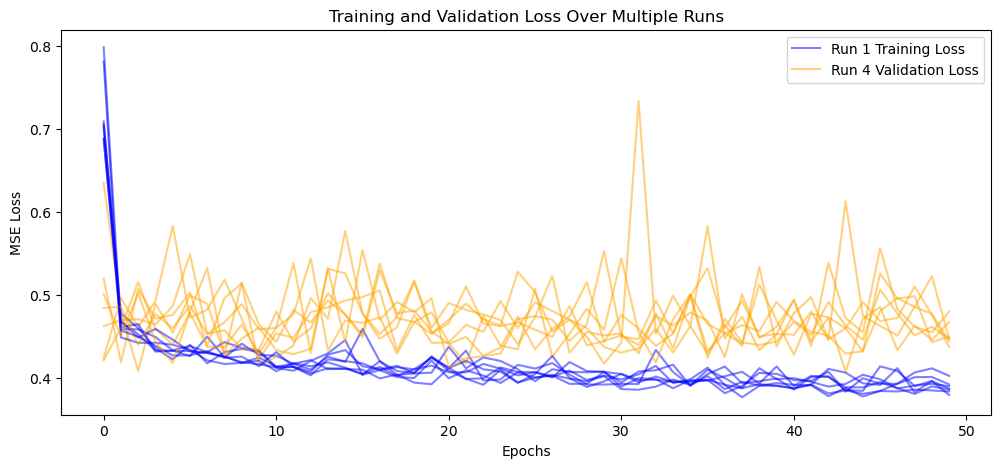

Average Test Loss Over 7 Runs: 0.5842


In [5]:

# Number of runs
n_runs = 7

# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="half").float()

# Prepare lists to store loss and evaluation metrics for all runs
all_NN_loss = []
all_NN_val_loss = []
all_test_loss = []

epochs = 50

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}\n-------------------------------")


    # Initialize the model
    model = fm.Fourier_model(W).float()

    # Define the loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')

    # Initialize the optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

    # Prepare lists to store loss for this run
    NN_loss = []
    NN_val_loss = []

    # Training loop for this run
    for t in range(epochs):
        print(f"Epoch {t+1}/{epochs}")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        val_loss = evaluate(val_dataloader, model, loss_fn)

        NN_loss.append(train_loss)
        NN_val_loss.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

    # Store losses for this run
    all_NN_loss.append(NN_loss)
    all_NN_val_loss.append(NN_val_loss)

    # Evaluate on test data for this run
    test_loss = evaluate(test_dataloader, model, loss_fn)
    all_test_loss.append(test_loss)
    print(f"Run {run+1} Test Loss: {test_loss:.4f}")

# Plot the training and validation losses for all runs
plt.figure(figsize=(12, 5))
for run in range(n_runs):
    x = np.arange(0, epochs)
    plt.plot(x, all_NN_loss[run], label=f"Run {run+1} Training Loss", color='blue', alpha=0.5)
    plt.plot(x, all_NN_val_loss[run], label=f"Run {run+1} Validation Loss", color='orange', alpha=0.5)

plt.title('Training and Validation Loss Over Multiple Runs')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

# Customizing the legend
handles, labels = plt.gca().get_legend_handles_labels()
label_order = [0, n_runs]  # Picks one label for training and one for validation
plt.legend([handles[idx] for idx in label_order], [labels[idx] for idx in label_order])

plt.show()


# Print average test loss over all runs
average_test_loss = sum(all_test_loss) / n_runs
print(f"Average Test Loss Over {n_runs} Runs: {average_test_loss:.4f}")


#### 3-b W is generated with Mode = "positive"
execution time = 37 min 12.2 s

Run 1/7
-------------------------------
Epoch 1/50
Train Loss: 0.6827
Validation Loss: 0.4393
Epoch 2/50
Train Loss: 0.4794
Validation Loss: 0.4316
Epoch 3/50
Train Loss: 0.4543
Validation Loss: 0.5069
Epoch 4/50
Train Loss: 0.4449
Validation Loss: 0.4345
Epoch 5/50
Train Loss: 0.4305
Validation Loss: 0.4587
Epoch 6/50
Train Loss: 0.4330
Validation Loss: 0.4475
Epoch 7/50
Train Loss: 0.4287
Validation Loss: 0.4303
Epoch 8/50
Train Loss: 0.4323
Validation Loss: 0.4298
Epoch 9/50
Train Loss: 0.4268
Validation Loss: 0.4515
Epoch 10/50
Train Loss: 0.4191
Validation Loss: 0.4338
Epoch 11/50
Train Loss: 0.4293
Validation Loss: 0.4395
Epoch 12/50
Train Loss: 0.4340
Validation Loss: 0.4644
Epoch 13/50
Train Loss: 0.4212
Validation Loss: 0.4188
Epoch 14/50
Train Loss: 0.4240
Validation Loss: 0.4207
Epoch 15/50
Train Loss: 0.4176
Validation Loss: 0.4444
Epoch 16/50
Train Loss: 0.4161
Validation Loss: 0.4449
Epoch 17/50
Train Loss: 0.4185
Validation Loss: 0.4372
Epoch 18/50
Train Loss: 0.4080
Val

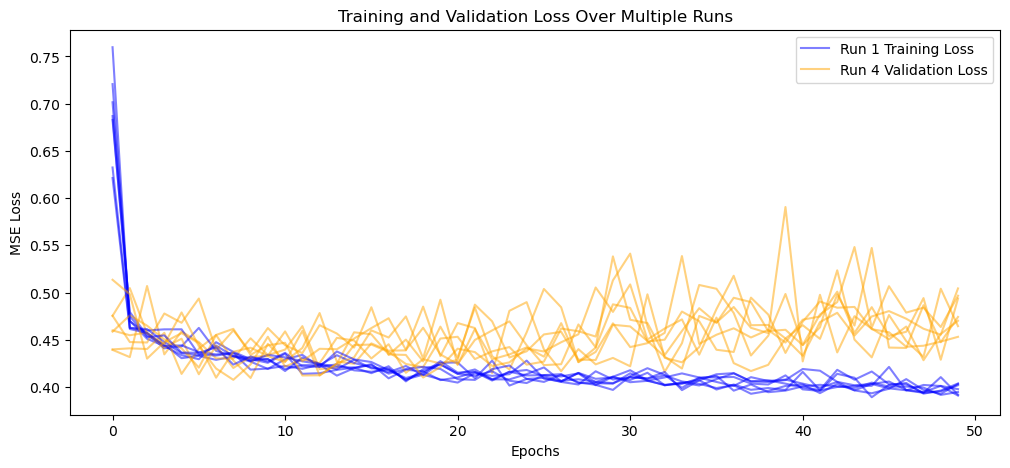

Average Test Loss Over 7 Runs: 0.7697


In [11]:

# Number of runs
n_runs = 7

# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="positive").float()

# Prepare lists to store loss and evaluation metrics for all runs
all_NN_loss = []
all_NN_val_loss = []
all_test_loss = []

epochs = 50

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}\n-------------------------------")


    # Initialize the model
    model = fm.Fourier_model(W).float()

    # Define the loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')

    # Initialize the optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

    # Prepare lists to store loss for this run
    NN_loss = []
    NN_val_loss = []

    # Training loop for this run
    for t in range(epochs):
        print(f"Epoch {t+1}/{epochs}")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        val_loss = evaluate(val_dataloader, model, loss_fn)

        NN_loss.append(train_loss)
        NN_val_loss.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

    # Store losses for this run
    all_NN_loss.append(NN_loss)
    all_NN_val_loss.append(NN_val_loss)

    # Evaluate on test data for this run
    test_loss = evaluate(test_dataloader, model, loss_fn)
    all_test_loss.append(test_loss)
    print(f"Run {run+1} Test Loss: {test_loss:.4f}")

# Plot the training and validation losses for all runs
plt.figure(figsize=(12, 5))
for run in range(n_runs):
    x = np.arange(0, epochs)
    plt.plot(x, all_NN_loss[run], label=f"Run {run+1} Training Loss", color='blue', alpha=0.5)
    plt.plot(x, all_NN_val_loss[run], label=f"Run {run+1} Validation Loss", color='orange', alpha=0.5)

plt.title('Training and Validation Loss Over Multiple Runs')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

# Customizing the legend
handles, labels = plt.gca().get_legend_handles_labels()
label_order = [0, n_runs]  # Picks one label for training and one for validation
plt.legend([handles[idx] for idx in label_order], [labels[idx] for idx in label_order])

plt.show()


# Print average test loss over all runs
average_test_loss = sum(all_test_loss) / n_runs
print(f"Average Test Loss Over {n_runs} Runs: {average_test_loss:.4f}")


#### 3-c  W is generated with Mode = "all"
execution time = 2355 min 36.8 s

Run 1/7
-------------------------------
Epoch 1/50
Train Loss: 0.6955
Validation Loss: 0.4693
Epoch 2/50
Train Loss: 0.4529
Validation Loss: 0.5062
Epoch 3/50
Train Loss: 0.4568
Validation Loss: 0.4458
Epoch 4/50
Train Loss: 0.4601
Validation Loss: 0.4792
Epoch 5/50
Train Loss: 0.4349
Validation Loss: 0.4321
Epoch 6/50
Train Loss: 0.4299
Validation Loss: 0.4755
Epoch 7/50
Train Loss: 0.4401
Validation Loss: 0.4582
Epoch 8/50
Train Loss: 0.4297
Validation Loss: 0.4197
Epoch 9/50
Train Loss: 0.4231
Validation Loss: 0.4278
Epoch 10/50
Train Loss: 0.4168
Validation Loss: 0.4553
Epoch 11/50
Train Loss: 0.4319
Validation Loss: 0.4265
Epoch 12/50
Train Loss: 0.4196
Validation Loss: 0.4573
Epoch 13/50
Train Loss: 0.4150
Validation Loss: 0.4271
Epoch 14/50
Train Loss: 0.4052
Validation Loss: 0.4377
Epoch 15/50
Train Loss: 0.4133
Validation Loss: 0.4418
Epoch 16/50
Train Loss: 0.4257
Validation Loss: 0.5154
Epoch 17/50
Train Loss: 0.4178
Validation Loss: 0.4559
Epoch 18/50
Train Loss: 0.3969
Val

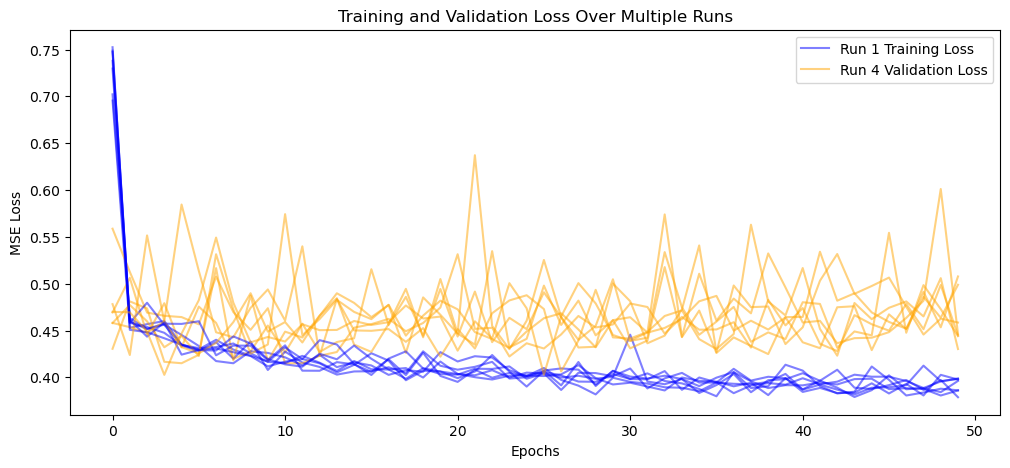

Average Test Loss Over 7 Runs: 0.6010


In [12]:

# Number of runs
n_runs = 7

# Define maximum frequency and dimension
max_freq = 2
dim = X_train.shape[1]  # Assuming X_scaled is a 2D tensor [n_samples, n_features]
W = utils.freq_generator(max_freq, dim, mode="all").float()

# Prepare lists to store loss and evaluation metrics for all runs
all_NN_loss = []
all_NN_val_loss = []
all_test_loss = []

epochs = 50

for run in range(n_runs):
    print(f"Run {run+1}/{n_runs}\n-------------------------------")


    # Initialize the model
    model = fm.Fourier_model(W).float()

    # Define the loss function
    loss_fn = torch.nn.MSELoss(reduction='mean')

    # Initialize the optimizer
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.1, history_size=50, line_search_fn="strong_wolfe")

    # Prepare lists to store loss for this run
    NN_loss = []
    NN_val_loss = []

    # Training loop for this run
    for t in range(epochs):
        print(f"Epoch {t+1}/{epochs}")
        train_loss = train(train_dataloader, model, loss_fn, optimizer)
        val_loss = evaluate(val_dataloader, model, loss_fn)

        NN_loss.append(train_loss)
        NN_val_loss.append(val_loss)

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Validation Loss: {val_loss:.4f}")

    # Store losses for this run
    all_NN_loss.append(NN_loss)
    all_NN_val_loss.append(NN_val_loss)

    # Evaluate on test data for this run
    test_loss = evaluate(test_dataloader, model, loss_fn)
    all_test_loss.append(test_loss)
    print(f"Run {run+1} Test Loss: {test_loss:.4f}")

# Plot the training and validation losses for all runs
plt.figure(figsize=(12, 5))
for run in range(n_runs):
    x = np.arange(0, epochs)
    plt.plot(x, all_NN_loss[run], label=f"Run {run+1} Training Loss", color='blue', alpha=0.5)
    plt.plot(x, all_NN_val_loss[run], label=f"Run {run+1} Validation Loss", color='orange', alpha=0.5)

plt.title('Training and Validation Loss Over Multiple Runs')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")

# Customizing the legend
handles, labels = plt.gca().get_legend_handles_labels()
label_order = [0, n_runs]  # Picks one label for training and one for validation
plt.legend([handles[idx] for idx in label_order], [labels[idx] for idx in label_order])

plt.show()


# Print average test loss over all runs
average_test_loss = sum(all_test_loss) / n_runs
print(f"Average Test Loss Over {n_runs} Runs: {average_test_loss:.4f}")
